Authors:

*Federico Barbero federico.barbero@cs.ox.ac.uk*.


Based off of a notebook by Francesco Di Giovanni, Cristian Bodnar, and James Rowbottom.

#Practical 4: Neural Diffusion 😀


Welcome to practical fourth and final practical for the GDL course - congratulations, you almost made it! In the first practical we learnt about the basics of GNNs. We then followed it up with slightly more advanced topics in the second. We finally introduced GNNs that respect rotational and translational symmetries in the third. In this practical we will look at the basics of Neural Diffusion. In particular we will see how GNNs can be seen as discretisations of PDEs.

# Installation

In [1]:
#@title [RUN] Install required libraries

!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

!pip install networkx

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip install mycolorpy
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#@title [RUN] Import modules
import numpy as np
import seaborn as sns
import math
import itertools
import scipy as sp
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.datasets import Planetoid, ZINC, GNNBenchmarkDataset
from torch_scatter import scatter_mean, scatter_max, scatter_sum, scatter_add
from torch_geometric.utils import to_dense_adj, to_undirected, remove_self_loops
from torch.nn import Embedding
from torch.nn import Parameter

import pdb

#for nice visualisations
import networkx as nx
import matplotlib.pyplot as plt

from mycolorpy import colorlist as mcp
import matplotlib.cm as cm

from typing import Mapping, Tuple, Sequence, List
import colorama

import scipy.linalg
from scipy.linalg import block_diag

In [3]:
# @title [RUN] Helper functions for plots and visualisations

####### VISUALISATIONS #######

####### PLOTS #######

def update_stats(training_stats, epoch_stats):
    """ Store metrics along the training
    Args:
      epoch_stats: dict containg metrics about one epoch
      training_stats: dict containing lists of metrics along training
    Returns:
      updated training_stats
    """
    if training_stats is None:
        training_stats = {}
        for key in epoch_stats.keys():
            training_stats[key] = []
    for key,val in epoch_stats.items():
        training_stats[key].append(val)

    return training_stats


def plot_stats(training_stats, figsize=(5, 5), name=""):
    """ Create one plot for each metric stored in training_stats
    """
    stats_names = [key[6:] for key in training_stats.keys() if key.startswith('train_')]
    f, ax = plt.subplots(len(stats_names), 1, figsize=figsize)
    if len(stats_names)==1:
        ax = np.array([ax])
    for key, axx in zip(stats_names, ax.reshape(-1,)):
        axx.plot(
            training_stats['epoch'],
            training_stats[f'train_{key}'],
            label=f"Training {key}")
        axx.plot(
            training_stats['epoch'],
            training_stats[f'val_{key}'],
            label=f"Validation {key}")
        axx.set_xlabel("Training epoch")
        axx.set_ylabel(key)
        axx.legend()
    plt.title(name)


def get_color_coded_str(i, color):
    return "\033[3{}m{}\033[0m".format(int(color), int(i))

def print_color_numpy(map, list_graphs):
    """ print matrix map in color according to list_graphs
    """
    list_blocks = []
    for i,graph in enumerate(list_graphs):
        block_i = (i+1)*np.ones((graph.num_nodes,graph.num_nodes))
        list_blocks += [block_i]
    block_color = block_diag(*list_blocks)
    
    map_modified = np.vectorize(get_color_coded_str)(map, block_color)
    print("\n".join([" ".join(["{}"]*map.shape[0])]*map.shape[1]).format(*[x for y in map_modified.tolist() for x in y]))
  

# Part 0: Warmup 

In our experiments we will be using Cora - one of the most popular datasets used in benchmarking GNNs. There are many variations of the Cora dataset originally presented in "Automating the Construction of Internet Portals with Machine Learning" by McCallum et al. (https://link.springer.com/article/10.1023/A:1009953814988). 

We will use the Cora dataset variant as presented in “FastGCN: Fast Learning with Graph Convolutional Networks via Importance Sampling” (https://arxiv.org/abs/1801.10247). It describes a citation network of 2708 papers and our task is classify each paper into one of 7 different categories. Some quick facts of this Cora variant:


*   There are 2708 papers (i.e. observations in the dataset)
  * 1208 train
  * 500 validation
  * 1000 test
*   Each paper is represented by a 1433 dimensional bag-of-words vector
*   Each paper belongs to one of 7 classes

Ignoring GNNs for a moment, our first attempt would be to use a simple model such as a feed forward MLP. In fact, it's always good practice to explore the task with simpler models for debugging and benchmarking. 

We will work with the cora dataset through a `CoraDataset` object which will download the dataset and provides the following methods:

- `train_val_test_split(self)`: returns torch tensors for `train_x`, `train_y`, `validation_x`, `validation_y`, `test_x`, `test_y`, corresponding to input x and target y for each of the train/val/test splits.
- `get_fullx(self)`: returns the feature matrix $\mathbf{X} \in \mathbb{R}^{|V| \times d}$ where $V$ is the set of nodes and $d$ the feature vector dimensionality.
- `get_adjacency_matrix(self)`: As the name suggests, returns a dense adjacency matrix $\mathbf{A}$
- `get_edge_index(self)`: Returns the sparse adjacency matrix in the form of a matrix of shape (2, num_edges)

In [4]:
# @title [RUN] `CoraDataset` implementation
# Let's get the Planetoid Cora dataset from 
# “FastGCN: Fast Learning with Graph Convolutional 
# Networks via Importance Sampling” (https://arxiv.org/abs/1801.10247)

from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj

class CoraDataset(object):
    def __init__(self):
        super(CoraDataset, self).__init__()
        cora_pyg = Planetoid(root='.dataset/Cora', name='Cora', split="full")
        self.cora_data = cora_pyg[0]
        self.train_mask = self.cora_data.train_mask
        self.valid_mask = self.cora_data.val_mask
        self.test_mask = self.cora_data.test_mask

    def train_val_test_split(self):
        train_x = self.cora_data.x[self.cora_data.train_mask]
        train_y = self.cora_data.y[self.cora_data.train_mask]

        valid_x = self.cora_data.x[self.cora_data.val_mask]
        valid_y = self.cora_data.y[self.cora_data.val_mask]

        test_x = self.cora_data.x[self.cora_data.test_mask]
        test_y = self.cora_data.y[self.cora_data.test_mask]
        return train_x, train_y, valid_x, valid_y, test_x, test_y

    def get_fullx(self):
        return self.cora_data.x

    def get_edge_index(self):
        return self.cora_data.edge_index

    def get_adjacency_matrix(self):
        # We will ignore this for the first part
        adj = to_dense_adj(self.cora_data.edge_index)[0]
        return adj

In [5]:
# Lets download our cora dataset and get the splits
cora_data = CoraDataset() ###<- n.b. should change this as "cora_data" is an attribute of CoraDataset
train_x, train_y, valid_x, valid_y, test_x, test_y = cora_data.train_val_test_split()

# Always check and confirm our data shapes match our expectations
print(f"Train shape x: {train_x.shape}, y: {train_y.shape}")
print(f"Val shape x: {valid_x.shape}, y: {valid_y.shape}")
print(f"Test shape x: {test_x.shape}, y: {test_y.shape}")

Processing...


Train shape x: torch.Size([1208, 1433]), y: torch.Size([1208])
Val shape x: torch.Size([500, 1433]), y: torch.Size([500])
Test shape x: torch.Size([1000, 1433]), y: torch.Size([1000])


Done!


In [6]:
# @title [RUN] Hyperparameters MLP

NUM_EPOCHS =  100 #@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}

#you can add more here if you need

In [7]:
# Lets implement a simple feed forward MLP
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SimpleMLP(nn.Module):
    """A simple feed forward neural network with no hidden layers

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
    """
    def __init__(self, input_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.layer_1 = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.layer_1(x)
        y_hat = F.log_softmax(x, dim=1)
        return y_hat

In [8]:
# Lets define some utility functions for training and computing performance metrics
# and then see how our model does!
def train_mlp_cora(x, y, model, optimiser):
    model.train()
    optimiser.zero_grad()
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimiser.step()
    return loss.data

def evaluate_mlp_cora(x, y, model):
    model.eval()
    y_hat = model(x)
    y_hat = y_hat.data.max(1)[1]
    num_correct = y_hat.eq(y.data).sum()
    num_total = len(y)
    accuracy = 100.0 * (num_correct/num_total)
    return accuracy

def train_eval_loop(model, train_x, train_y, valid_x, valid_y, test_x, test_y):
    optimiser = optim.Adam(model.parameters(), lr=LR)
    training_stats = None
    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train_mlp_cora(train_x, train_y, model, optimiser)
        train_acc = evaluate_mlp_cora(train_x, train_y, model)
        valid_acc = evaluate_mlp_cora(valid_x, valid_y, model)
        if epoch % 10 == 0:
            print(f"Epoch {epoch} with train loss: {train_loss:.3f} train accuracy: {train_acc:.3f}",
                    f"validation accuracy: {valid_acc:.3f}")
        # store the loss and the accuracy for the final plot
        epoch_stats = {'train_acc': train_acc, 'val_acc': valid_acc, 'epoch':epoch}
        training_stats = update_stats(training_stats, epoch_stats)
    # Lets look at our final test performance
    test_acc = evaluate_mlp_cora(test_x, test_y, model)
    print(f"Our final test accuracy for the SimpleMLP is: {test_acc:.3f}")
    return training_stats

Epoch 0 with train loss: 1.953 train accuracy: 16.722 validation accuracy: 15.000
Epoch 10 with train loss: 1.815 train accuracy: 57.864 validation accuracy: 42.800
Epoch 20 with train loss: 1.690 train accuracy: 63.493 validation accuracy: 47.200
Epoch 30 with train loss: 1.577 train accuracy: 68.295 validation accuracy: 50.000
Epoch 40 with train loss: 1.473 train accuracy: 74.834 validation accuracy: 51.600
Epoch 50 with train loss: 1.377 train accuracy: 79.553 validation accuracy: 54.600
Epoch 60 with train loss: 1.289 train accuracy: 83.858 validation accuracy: 59.600
Epoch 70 with train loss: 1.209 train accuracy: 86.093 validation accuracy: 60.800
Epoch 80 with train loss: 1.135 train accuracy: 88.411 validation accuracy: 61.800
Epoch 90 with train loss: 1.068 train accuracy: 90.563 validation accuracy: 62.400
Our final test accuracy for the SimpleMLP is: 65.100


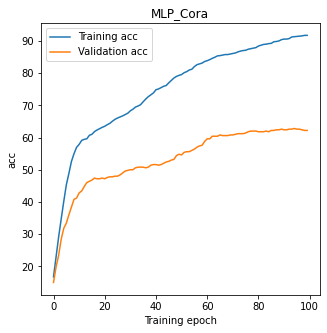

In [9]:
# Instantiate our model 
model = SimpleMLP(input_dim=train_x.shape[-1], output_dim=7)

# Run training loop
train_stats_mlp_cora = train_eval_loop(model, train_x, train_y, valid_x, valid_y, test_x, test_y)
plot_stats(train_stats_mlp_cora, name="MLP_Cora")

# Part 1: From Heat Diffusion to GNNs

Before we dive into implementing some models, let's implement some simple functions that will be helpful later.






## 💻**Task 1:** Compute the symmetric normalised adjacency matrix of a graph with added self-loops. 

For a graph without self loops, this is given by $$(\mathbf{D} + \mathbf{I})^{-
1/2}(\mathbf{A} + \mathbf{I})(\mathbf{D} + \mathbf{I})^{-1/2} = \tilde{\mathbf{D}}^{-
1/2}\tilde{\mathbf{A}}\tilde{\mathbf{D}}^{-1/2}$$ Where $\tilde{\mathbf{A}}$ is the $n \times n$ adjacency matrix with added self-loops. $\tilde{\mathbf{D}}$ is the degree matrix of $\tilde{\mathbf{A}}$, a diagonal matrix with entry $ii$ being the degree of node $i$.

The function below takes as input the dense matrix $A$ and should return a sparse version of the normalised adjacency in the coordinate format: https://pytorch.org/docs/stable/sparse.html#sparse-coo-docs. Make sure you use `torch.sparse.mm` when possible.

In [10]:
import torch_geometric.utils as tgutils

def sym_norm_adj(A):
    #### Create the symmetric normalised adjacency from the dense adj matrix A
    # This should return a sparse adjacency matrix. (torch sparse coo tensor format)
    I = torch.eye(A.shape[0])
    AI = A+I
    DI_vec = A.sum(dim=1)+1
    DI = torch.diag(DI_vec.pow(-0.5))

    AI = AI.to_sparse()
    DI = DI.to_sparse()
    return DI @ AI @ DI

## Graph Laplacians

The graph Laplacian of a graph $\mathbf{L}$ is an extremely important matrix originally stemming from Spectral Graph Theory - a field that studies the interplay between graphs and the spectrum of adjacency matrices and Laplacian matrices. It is also commonly used in the GNN literature as well. It is defined as:

$$\mathbf{L} = \mathbf{D} - \mathbf{A}$$

This is a positive semi-definite operator that acts over node signals and returns "smoothened" versions of these node signals. By $\Delta$ we denote the normalised version of the graph Laplacian (with added self-loops). This takes the form:

$$\Delta = \tilde{\mathbf{D}}^{-
1/2}\tilde{\mathbf{L}}\tilde{\mathbf{D}}^{-1/2} = \tilde{\mathbf{D}}^{-
1/2}(\tilde{\mathbf{D}} - \tilde{\mathbf{A}}) \tilde{\mathbf{D}}^{-1/2} = \mathbf{I} - \tilde{\mathbf{D}}^{-
1/2}\tilde{\mathbf{A}} \tilde{\mathbf{D}}^{-1/2}$$

Where $\tilde{\mathbf{A}} = \mathbf{A} + \mathbf{I}$. The eigenvalues and eigenvectors of the graph Laplacian hold a lot of very useful information. They are tied to the connectivity of the graph and, perhaps unsurprinsigly, they are heavily used in many applications such as spectral graph clustering.

## Dirichilet Energy
For a feature matrix $X$, the Dirichlet energy is defined as $Tr(X^T \Delta X)$, where $\Delta$ is the symmetric normalised Laplacian. This is a measure of how "smooth" the signal is. 

If our signal is $1$-dimensional, then the Dirichilet energy is simply $\mathbf{x}^T \Delta \mathbf{x}$. The (non-normalised) Dirichilet energy looks like: 

$$\mathbf{x}^T \Delta \mathbf{x} = \sum_{i \sim j} (\mathbf{x}_i - \mathbf{x}_j)^2$$

It is therefore clear, assuming real-valued signals, that $\mathbf{x}^T \Delta \mathbf{x} \geq 0$ and that values close to $0$ are ones in which the signal is "smooth" as we jump from node to node. We achieve $0$ (assuming the graph is connected) only when we have a constant signal. The constant signal is in fact an eigenvector of the (non-normalised) Laplacian, with corresponding eigenvalue $0$. This intuition holds for the normalised Laplacian as well, but with some additional normalisation book-keeping.

## 💻**Task 2:** Implement a function to compute the Dirichlet energy

Test your code by computing the Dirichlet energy on the raw features of Cora. You should get a value of around 30000.

In [11]:
def dirichlet_energy(X, adj_norm):
    # X is a matrix of shape (num_nodes, feature_channels)
    # adj_norm is a torch sparse coo tensor 
    ######## Your code here ##############
    n = X.shape[0]
    delta = torch.eye(n) - adj_norm
    energy = torch.trace(X.T @ delta @ X)
    ######################################
    return energy

In [12]:
X = cora_data.get_fullx()
adj = cora_data.get_adjacency_matrix()
norm_adj = sym_norm_adj(adj)
energy = dirichlet_energy(X, norm_adj)
print(f"Initial Dirichlet enegy: {energy}")

Initial Dirichlet enegy: 30079.66015625


## 💻**Task 3:** Relationship between GCN and the Heat equation

Recall the form of the GCN model: 

$$\mathbf{X}_{t+1} = \sigma(\mathbf{D}^{-1/2}\hat{\mathbf{A}}\mathbf{D}^{-1/2}\mathbf{X}_{t}\mathbf{W}_t)$$

with $\mathbf{W}_t$ being a learnable weight matrix and $\sigma$ a non-linear function. By $t$ we denote the layer of the model. 

Your task is to derive the GCN model from a unit timestep Euler discretisation of the heat diffuson PDE (over a graph) - in other words to show that the GCN model behaves like a discretised version of the Heat equation:

$$
\frac{\partial \mathbf{X}_t}{\partial t} = -\Delta \mathbf{X}_t
$$

Hint: The unit-time step ($\tau = 1$) Euler discretisation of the above PDE is:

$$\frac{X_{t+1} - X_t}{\tau} = - \Delta \mathbf{X}_t$$

Answer here:




$$
\begin{align}
\mathbf{X}_{t+1} 
& = (I -  \Delta) \mathbf{X}_t \\
& = (\tilde{\mathbf{D}}^{-1/2}\tilde{\mathbf{A}} \tilde{\mathbf{D}}^{-1/2})  \mathbf{X}_t
\end{align}
$$

Let $W_t = I$, $\sigma=id$

## 💻**Task 4:** Implement the heat layer

We will now implement the Euler discretisation of heat diffusion. The heat diffusion equation is given by $\frac{\partial \mathbf{X}_t}{\partial t} = -\Delta \mathbf{X}_t$. For a step size $\tau$, we obtain the following layer $\mathbf{X}_{t+1} = \mathbf{X}_t - \tau \Delta \mathbf{X}_t$.

In [13]:
class HeatLayer(nn.Module):
    """Heat diffusion layer to be implemented by students of practical

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        A (torch.Tensor): 2-D adjacency matrix
    """
    def __init__(self, input_dim, output_dim, A, step_size, use_W=True, nonlinear=False):
        super(HeatLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A = A
        self.step_size = step_size
        self.adj_norm = sym_norm_adj(A)

    def forward(self, x):
        ##########################
        # YOUR ANSWER HERE
        
        # No need for weights or non-linearity
        # Ignore some of the extra fields in the __init__ method
        # As they are not needed
        
        delta = torch.eye(x.shape[0]) - self.adj_norm
        out = x - self.step_size * delta @ x
        
        return out
        ##########################

We provide below the code necessary to run these layers by stacking multiple such layers. Each layer corresponds to a discretised step of an underlying dynamical system. 

In [14]:
#@title GNN Setup
class GNN(nn.Module):
    """Simple encoder decoder GNN model using the various conv layers implemented by students

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        hidden_dim (int): Dimensionality of the hidden feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        time (int):
        step_size (int):
        A (torch.Tensor): 2-D adjacency matrix
        conv_type (str):
    """
    def __init__(self, input_dim, hidden_dim, output_dim, T, step_size, A, conv_type='gcn'):
        super(GNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layers = int(T // step_size)
        self.A = A

        self.encoder = nn.Linear(input_dim, hidden_dim)
        if conv_type == 'heat':
          self.conv_layer = HeatLayer(hidden_dim, hidden_dim, A, step_size)
        elif conv_type == 'graff':
          self.conv_layer = GRAFFLayer(hidden_dim, hidden_dim, A, step_size)
        self.decoder = nn.Linear(hidden_dim, output_dim)

        self.evolution = []


    def forward(self, x):
        self.evolution = []
        x = self.encoder(x)
        
        for _ in range(self.layers):
          self.evolution.append(x)
          x = self.conv_layer(x) #note implicitly we are sharing weights by using 1 conv block repeated
        
        self.evolution.append(x)
        x = self.decoder(x)
  
        y_hat = F.log_softmax(x, dim=1)
        return y_hat

In [15]:
#@title Training setup

def train_gnn_cora(X, y, mask, model, optimiser):
    model.train()
    optimiser.zero_grad()
    y_hat = model(X)[mask]
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimiser.step()
    return loss.data

def evaluate_gnn_cora(X, y, mask, model):
    model.eval()
    y_hat = model(X)[mask]
    y_hat = y_hat.data.max(1)[1]
    num_correct = y_hat.eq(y.data).sum()
    num_total = len(y)
    accuracy = 100.0 * (num_correct/num_total)
    return accuracy

# Training loop
def train_eval_loop_gnn_cora_evolutions(model, train_x, train_y, train_mask, 
                        valid_x, valid_y, valid_mask, 
                        test_x, test_y, test_mask
                    ):
    optimiser = optim.Adam(model.parameters(), lr=LR)
    training_stats = None
    evolutions = {}
    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train_gnn_cora(train_x, train_y, train_mask, model, optimiser)
        train_acc = evaluate_gnn_cora(train_x, train_y, train_mask, model)
        valid_acc = evaluate_gnn_cora(valid_x, valid_y, valid_mask, model)
        if epoch % 10 == 0:
            print(f"Epoch {epoch} with train loss: {train_loss:.3f} train accuracy: {train_acc:.3f} validation accuracy: {valid_acc:.3f}")
            evolutions[f"epoch_{epoch}"] = model.evolution ### <-- adding this line to track the evolution

        # store the loss and the accuracy for the final plot
        epoch_stats = {'train_acc': train_acc, 'val_acc': valid_acc, 'epoch':epoch}
        training_stats = update_stats(training_stats, epoch_stats)
    # Lets look at our final test performance
    test_acc = evaluate_gnn_cora(test_x, test_y, test_mask, model)
    print(f"Our final test accuracy is: {test_acc:.3f}")
    return training_stats, evolutions

def evaluate_gnn_cora_evol(X, y, mask, model):
    model.eval()
    y_hat = model.decoder(X)[mask]
    y_hat = y_hat.data.max(1)[1]
    num_correct = y_hat.eq(y.data).sum()
    num_total = len(y)
    accuracy = 100.0 * (num_correct/num_total)
    return accuracy

In [16]:
#@title [RUN] Plotting methods
def get_evolution_stats(model, CoraDataset, evolutions, epoch_idxs=[-1]):

    A = CoraDataset.get_adjacency_matrix()
    edge_index = CoraDataset.cora_data.edge_index
    adj_norm = sym_norm_adj(A)
    train_mask = CoraDataset.train_mask
    valid_mask = CoraDataset.valid_mask
    test_mask = CoraDataset.test_mask

    evol_stats = {}
    for epoch in epoch_idxs:
      epoch_idx=f"epoch_{epoch}"
      evol_stats[epoch_idx] = {}

      train_accs = []
      val_accs = []
      test_accs = []
      energy = []

      for x_t in evolutions[epoch_idx]:
          logits = model.decoder(x_t)  
          y_t = F.log_softmax(logits, dim=1)

          train_accs.append(evaluate_gnn_cora_evol(x_t, train_y, train_mask, model))
          val_accs.append(evaluate_gnn_cora_evol(x_t, valid_y, valid_mask, model))
          test_accs.append(evaluate_gnn_cora_evol(x_t, test_y, test_mask, model))
          energy.append(dirichlet_energy(x_t, adj_norm))

      evol_stats[epoch_idx]['train_accs'] = train_accs
      evol_stats[epoch_idx]['valid_accs'] = val_accs
      evol_stats[epoch_idx]['test_accs'] = test_accs
      evol_stats[epoch_idx]['energy'] = energy

      return evol_stats


def plot_evol_stats(evol_stats, figsize=(5, 5), name=""):
    """ Create four plots for each epoch stored in evol_stats
    """
    sorted_epochs = sorted(list(evol_stats.keys()))
    
    f, ax = plt.subplots(len(sorted_epochs), 2, figsize=figsize)

    for i, epoch in enumerate(sorted_epochs):
      stats = evol_stats[epoch]
      if len(sorted_epochs) > 1:
          #plot accuracies and homophily
          ax[i, 0].plot(torch.stack(evol_stats[epoch]['train_accs']).numpy())
          ax[i, 0].plot(torch.stack(evol_stats[epoch]['valid_accs']).numpy())
          ax[i, 0].plot(torch.stack(evol_stats[epoch]['test_accs']).numpy())
          ax[i, 0].legend()
          ax[0].set_ylabel("Accuracy")
          ax[0].set_xlabel("Time Evolution")
          #plot dirichlet energy
          ax[i, 1].plot(torch.stack(evol_stats[epoch]['energy']).numpy())
          ax[1].set_ylabel("Dirichilet Energy")
          ax[1].set_xlabel("Time Evolution")
          ax[0].set_title("Accuracy Evolution")
          ax[1].set_title("Dirichilet Energy Evolution")
          ax[i, 1].legend()
      else:
          ax[0].plot(torch.stack(evol_stats[epoch]['train_accs']).numpy(), label='Train accuracy')
          ax[0].plot(torch.stack(evol_stats[epoch]['valid_accs']).numpy(), label='Validation accuracy')
          ax[0].plot(torch.stack(evol_stats[epoch]['test_accs']).numpy(), label='Test accuracy')
          ax[0].legend()
          #plot dirichlet energy
          ax[1].plot(torch.stack(evol_stats[epoch]['energy']).detach().numpy(), label='Energy')
          ax[0].set_ylabel("Accuracy")
          ax[0].set_xlabel("Time Evolution")
          ax[1].set_ylabel("Dirichilet Energy")
          ax[1].set_xlabel("Time Evolution")
          ax[0].set_title("Accuracy Evolution")
          ax[1].set_title("Dirichilet Energy Evolution")
        #   ax[1].ylabel("Energy")
          ax[1].legend()

In [17]:
# @title [RUN] Run heat diffusion

CONV_TYPE =  "heat"
NUM_EPOCHS =  100 #@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}

In [18]:
# Instantiate our model and optimiser
Cora  = CoraDataset()
A = Cora.get_adjacency_matrix()
X = Cora.get_fullx()
model = GNN(input_dim=train_x.shape[-1], hidden_dim=32, output_dim=7, T=3, step_size=1.0, A=A, conv_type=CONV_TYPE)
###todo need to check why heat equation is so slow - probs not sparse

print(train_x.shape)
train_mask = Cora.train_mask
valid_mask = Cora.valid_mask
test_mask = Cora.test_mask

# Run training loop
train_stats_gnn_cora, evolutions = train_eval_loop_gnn_cora_evolutions(model, X, train_y, train_mask, 
                                          X, valid_y, valid_mask, 
                                          X, test_y, test_mask
                                       )


torch.Size([1208, 1433])
Epoch 0 with train loss: 1.927 train accuracy: 28.146 validation accuracy: 31.200
Epoch 10 with train loss: 1.780 train accuracy: 30.629 validation accuracy: 34.800
Epoch 20 with train loss: 1.629 train accuracy: 44.454 validation accuracy: 45.800
Epoch 30 with train loss: 1.470 train accuracy: 60.679 validation accuracy: 58.600
Epoch 40 with train loss: 1.303 train accuracy: 72.103 validation accuracy: 69.000
Epoch 50 with train loss: 1.139 train accuracy: 77.649 validation accuracy: 74.400
Epoch 60 with train loss: 0.985 train accuracy: 82.781 validation accuracy: 78.600
Epoch 70 with train loss: 0.848 train accuracy: 85.927 validation accuracy: 81.200
Epoch 80 with train loss: 0.731 train accuracy: 88.162 validation accuracy: 84.000
Epoch 90 with train loss: 0.634 train accuracy: 89.735 validation accuracy: 84.400
Our final test accuracy is: 86.400


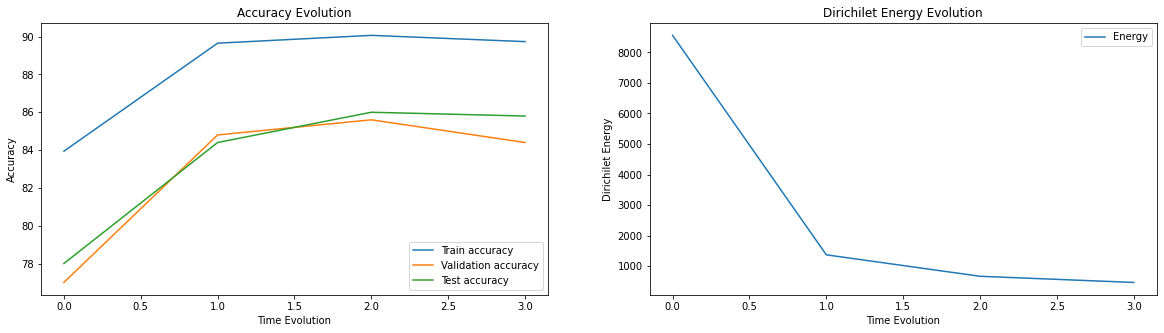

In [19]:
evol_stats = get_evolution_stats(model, Cora, evolutions, epoch_idxs=[NUM_EPOCHS-10])
plot_evol_stats(evol_stats, figsize=(20, 5), name="GNN_Cora")

## 💻**Task 5:** Dirichilet energy behaviour

Examine the plots above, how does the Dirichilet energy behave as we run the Heat diffusion process? Why does this happen? Can you relate this to over-smoothing? 

*Hint: This is very much related to the behaviour of Heat diffusion in a physical system.*

Answer here.

## 💻**(Bonus) Task 6:** Implement a GRAFF layer

We will now implement a simple GRAFF layer from https://arxiv.org/abs/2206.10991. This is like a residual GCN with symmetric weight matrix $\mathbf{W}$ and no non-linearities (although you are welcome to play around with nonlinear activations). 

Denoting the symmetric normalised adjacency by $\tilde{\mathbf{A}}$, we want to implement $\mathbf{X}_{t+1} = \mathbf{X}_t + \tau\tilde{\mathbf{A}}\mathbf{X}_t \mathbf{W}_t$, where $\mathbf{W}_t$ is constrained to be symmetric and $\tau$ is again the step-size. Think how you can construct $\mathbf{W}_t$ so that is is forced to be symmetric. The technical details of GRAFF are beyond the scope of this practical - one take-home message is that we are able to construct models (such as GRAFF) in which the Dirichilet energy does not have to necessarily vanish (like in GCNs for instance). In particular, this behaviour heavily depends on the spectrum of $\mathbf{W}_t$. 

In [20]:

class GRAFFLayer(nn.Module):
    """GRAFF layer to be implemented by students of practical

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        A (torch.Tensor): 2-D adjacency matrix
    """
    def __init__(self, input_dim, output_dim, A, step_size, use_W=True, nonlinear=False):
        super(GRAFFLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_W = use_W
        self.nonlinear = nonlinear
        self.A = A
        self.step_size = step_size
        self.adj_norm = sym_norm_adj(A)
        self.W = nn.Parameter(torch.Tensor(input_dim, output_dim))
        nn.init.xavier_uniform_(self.W)
        self.linear = nn.Linear(input_dim, output_dim, bias=False)

    def forward(self, x):
        ##########################
        # YOUR ANSWER HERE 
        
        out = x + self.step_size * self.adj_norm @ x @ (self.W + self.W.T)

        return out
        ##########################


In [21]:
# @title [RUN] Run GRAFF diffusion

CONV_TYPE =  "graff"
NUM_EPOCHS =  100 #@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}

In [24]:
# Instantiate our model and optimiser
Cora  = CoraDataset()
A = Cora.get_adjacency_matrix()
X = Cora.get_fullx()
model = GNN(input_dim=train_x.shape[-1], hidden_dim=32, output_dim=7, T=3, step_size=1.0, A=A, conv_type=CONV_TYPE)
###todo need to check why heat equation is so slow - probs not sparse

print(train_x.shape)
train_mask = Cora.train_mask
valid_mask = Cora.valid_mask
test_mask = Cora.test_mask

# Run training loop
train_stats_gnn_cora, evolutions = train_eval_loop_gnn_cora_evolutions(model, X, train_y, train_mask, 
                                          X, valid_y, valid_mask, 
                                          X, test_y, test_mask
                                       )

torch.Size([1208, 1433])
Epoch 0 with train loss: 1.981 train accuracy: 27.815 validation accuracy: 27.000
Epoch 10 with train loss: 0.774 train accuracy: 87.666 validation accuracy: 81.600
Epoch 20 with train loss: 0.302 train accuracy: 93.460 validation accuracy: 87.000
Epoch 30 with train loss: 0.161 train accuracy: 96.109 validation accuracy: 87.000
Epoch 40 with train loss: 0.098 train accuracy: 97.517 validation accuracy: 87.400
Epoch 50 with train loss: 0.065 train accuracy: 98.344 validation accuracy: 86.200
Epoch 60 with train loss: 0.046 train accuracy: 98.924 validation accuracy: 85.800
Epoch 70 with train loss: 0.033 train accuracy: 99.421 validation accuracy: 85.200
Epoch 80 with train loss: 0.025 train accuracy: 99.669 validation accuracy: 85.000
Epoch 90 with train loss: 0.020 train accuracy: 99.834 validation accuracy: 84.800
Our final test accuracy is: 83.800


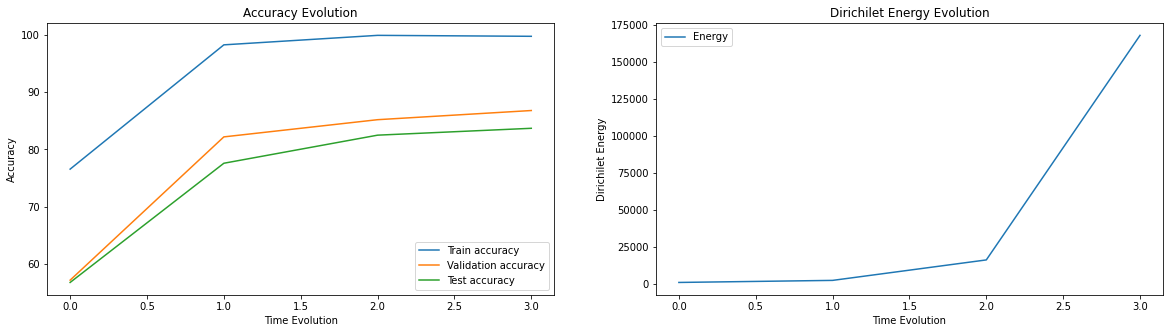

In [23]:
evol_stats = get_evolution_stats(model, Cora, evolutions, epoch_idxs=[NUM_EPOCHS-10])
plot_evol_stats(evol_stats, figsize=(20, 5), name="GNN_Cora")

In this practical we started by looking at graph Laplacians and Dirichilet energies. We then related the Heat diffusion equation to GCNs. We saw how this type of process acts as a smoothing process of the features, in other words - the Dirichilet energy goes to $0$ as we increase the number of layers. In the bonus task we looked at a technique designed to change this behaviour. Hope you enjoyed the practicals! 😀 

Fin.

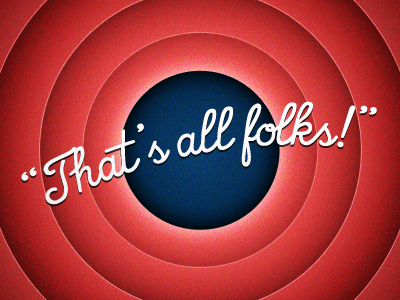